#### Author:
Simon Hackl, 04.03.2021

Integrative Transcriptomics (IBMI), University Tübingen

#### Project:
Elaboration of a best practice for hybrid and long read de novo assembly of bacterial genomes utilizing Illumina and Oxford Nanopore Technologies reads

---

This notebook is used to visualize the results of the `S7_assemblyEvaluation.sh` script regarding the metrics reported with Quast. In order to re-run this notebook please ensure that all result files were generated and stored in the directories as it is described in the respective scripts.

---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import plotly.graph_objects as go
import seaborn as sns

import gzip

from functools import reduce
from PIL import ImageFont

In [2]:
"""
The following code is based on https://jwalton.info/Embed-Publication-Matplotlib-Latex/ 
and is used to format generated plots in LaTeX style.
"""

plt.style.use('default')

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

def set_size(width, height=False, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    if height :
        fig_height_in = height * fraction * inches_per_pt
    else :
        fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

---
#### Visualization of selected metrics reported with Quast:
In the following selected metrics reported with Quast, i.e. the ones that were most differentiated with respect to their values among the single assemblers and sets, are each plotted as a heatmap, depicting the sets on the x axis and the single assemblers on the y axis.

In [3]:
# We do not want to use the Quast reports labels as y axis values and therefore define a dicitonary with alternative names.
assemblerNames = { "canu": "Canu",
                   "canu_medaka": "Canu (Medaka)",
                   "flye": "Flye",
                   "raven": "Raven",
                   "unicycler~longread": "Unicycler (longread)",
                   "unicycler~hybrid": "Unicycler (hybrid)",
                   "trycycler": "Trycycler",
                   "trycycler_medaka": "Trycycler (Medaka)",
                   "trycycler_medaka_pilon": "Trycycler (Medaka + Pilon)" }
# Generate one list of assembler names to avoid redundant definitions.
assemblers = list( assemblerNames.keys( ) )
# Definition of a dictionary with which the report files are stored as keys and alternative file names, i.e. the set names,
# are stored as values for visualizing them on the x axis.
files = { './results/quast/CFT073/report.tsv' : "CFT073",
          './results/quast/MGH78578/report.tsv' : "MGH78578",
          './results/quast/RN4220~guppy3210/report.tsv' : "RN4220 (Guppy 3.2.1.0)",
          './results/quast/RN4220~guppy4011/report.tsv' : "RN4220 (Guppy 4.0.1.1)" }
# Instead of reporting absolute values for recovered and predicted genes, they will be reported relative to the total number
# of reference features. The following dictionary is used to access these for the single sets. The values are taken from the
# Quast reports manually.
geneticFeatures = { "CFT073" : 5288,
                    "MGH78578" : 5689,
                    "RN4220 (Guppy 3.2.1.0)" : 2913,
                  "RN4220 (Guppy 4.0.1.1)" : 2913}

In [4]:
def plotFeatureHeatmap( feature, title, geneticFeatures = False, showXLabels = True, showYLabels = True, files = files ) :
    ''' Visualizes one selected feature/metric of a Quast .tsv report as heatmap.
    
    Parameters
    ----------
    feature: str
        The feature/metric to be visualized, has to be contained in the Quast .tsv reports specified with fileNames.
    title: str
        The title for the plot.
    geneticFeatures: bool or dict
        If set to False (default) and the feature is recovered or predicted genes, the absolute counts will be plotted.
        If a dict is given, it should contain the the values of the files dictionary as keys and an integer as values.
    showXLabels: bool
        If set to False, no x-axis ticks, ticklabels and labels will be shown. Default is True.
    showyLabels: bool
        If set to False, no y-axis ticks, ticklabels and labels will be shown. Default is True.
    files: dict
        Has to contain valid Quast .tsv report file paths as keys and alternative file names as values.
    '''
    # Extract file paths from files dictionary.
    fileNames = list( files.keys( ) )
    dfs = [ ]
    # Parse and store all specified files in a single Pandas dataframe.   
    for fileName in fileNames :
        df = pd.read_csv( open( fileName ), delimiter = '\t' )
        df.set_index( "Assembly", inplace = True )
        df = df[ df.index.isin( [ feature ] ) ]
        df = df.drop( [ 'haslr' ], axis = 1, errors = 'ignore' )
        
        # If the specified feature is '# genomic features' process the stored strings into integers representing only fully recovered genes.
        if feature == "# genomic features" :
            df = df.T
            df[ "# genomic features" ] = [ float( val.split( " + " )[ 0 ] ) for val in df[ "# genomic features" ].tolist( ) ]
        else :
            df = df.T.astype( float )
            
        df.rename( index = assemblerNames, inplace = True )
        df.rename( columns = { feature : files[ fileName ] }, inplace = True )
        dfs.append( df )
    
    df = pd.concat( dfs, axis = 1 )
    
    # If geneticFeatures is not False, report the recovered or predicted genes relative to the total number of reference features.
    if geneticFeatures and feature in [ "# predicted genes (unique)", "# genomic features" ] :
        df[ "CFT073" ] = [ value / geneticFeatures[ "CFT073" ] for value in df[ "CFT073" ] ]
        df[ "MGH78578" ] = [ value / geneticFeatures[ "MGH78578" ] for value in df[ "MGH78578" ] ]
        df[ "RN4220 (Guppy 3.2.1.0)" ] = [ value / geneticFeatures[ "RN4220" ] for value in df[ "RN4220 (Guppy 3.2.1.0)" ] ]
        df[ "RN4220 (Guppy 4.0.1.1)" ] = [ value / geneticFeatures[ "RN4220" ] for value in df[ "RN4220 (Guppy 4.0.1.1)" ] ]

    # Plot the heatmap.
    plt.figure( figsize = set_size( 300, 400 ) )
    sns.heatmap( df, annot = True, cmap = "vlag", linewidths = .5, fmt=".4" )
    
    # Show x and y labels and ticks based on the passed parameters.
    if showYLabels :
        plt.ylabel( "Assembler" )
    else :
        plt.ylabel( "" )
        plt.yticks( np.arange( 0.5, 9.5 ), "" )
    
    if showXLabels :
        plt.xlabel( "Reference" )
        plt.xticks( rotation = 30, ha="right", rotation_mode="anchor" )
    else :
        plt.xlabel( "" )
        plt.xticks( np.arange( 0.5, 4.5 ), "" )
    
    plt.title( title )
    plt.show( )

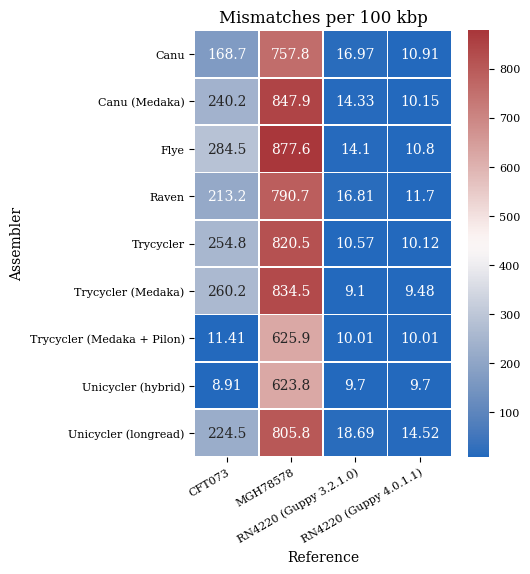

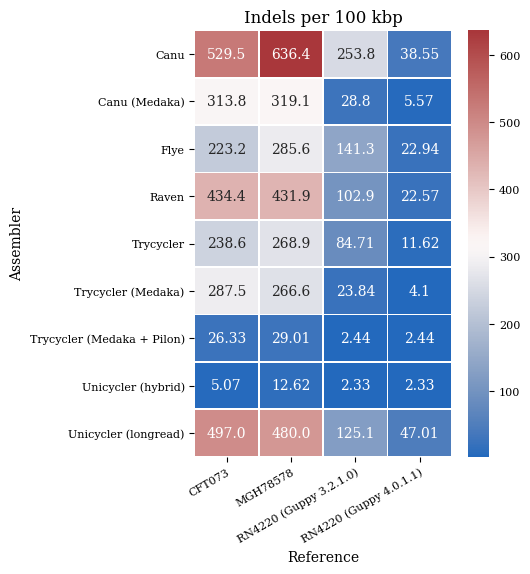

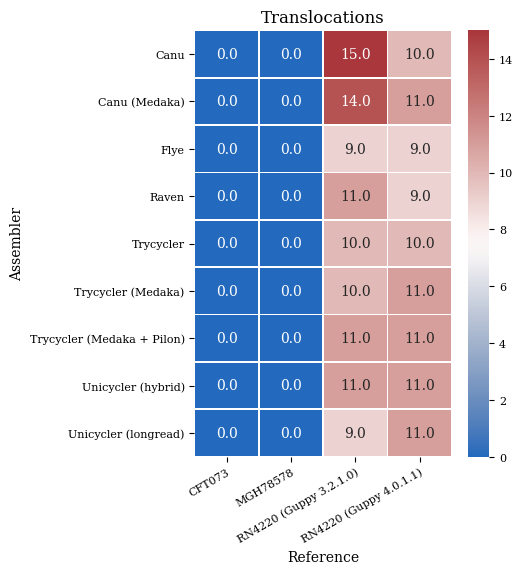

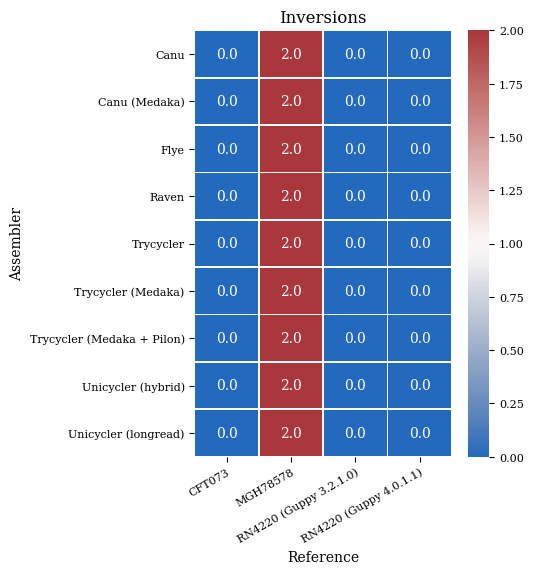

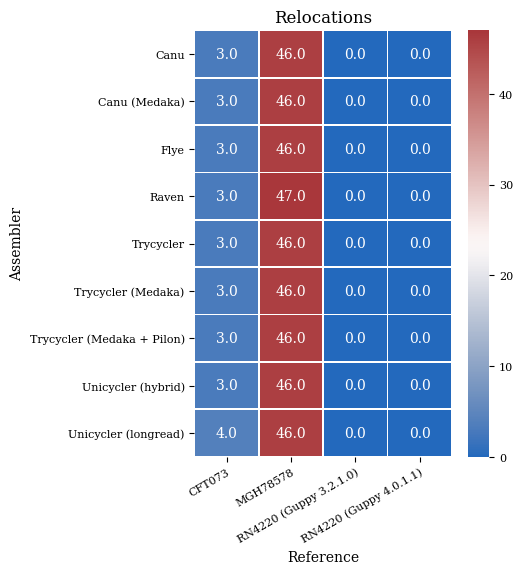

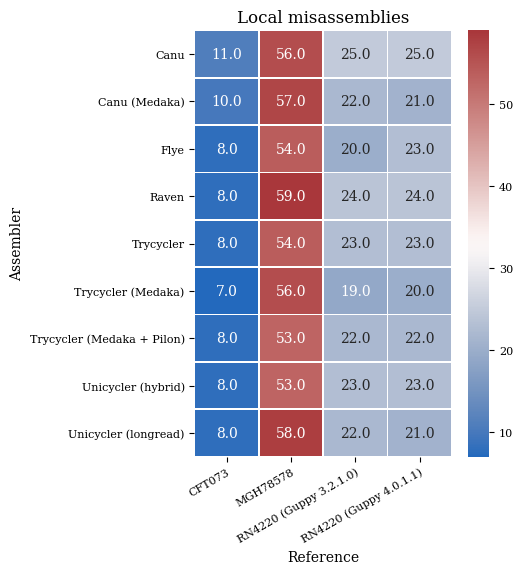

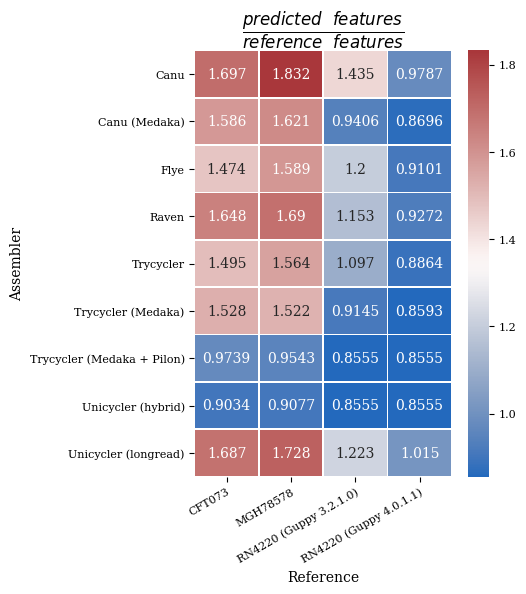

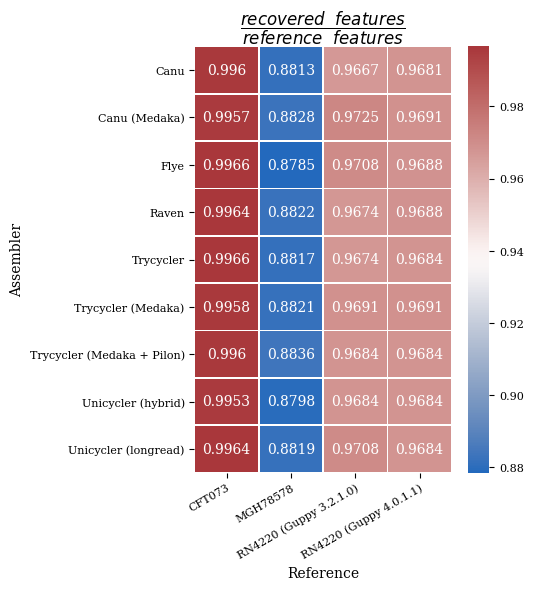

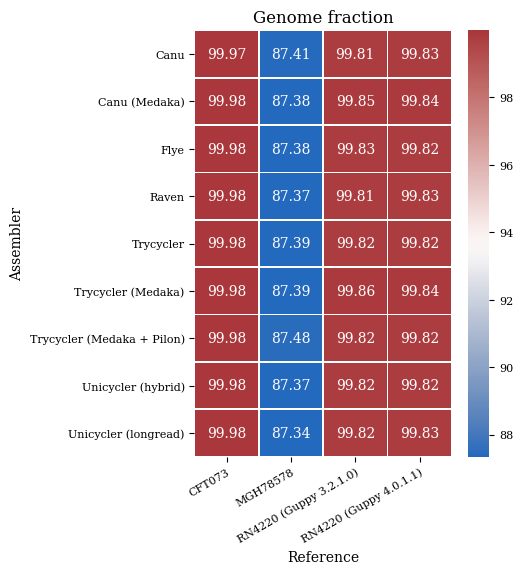

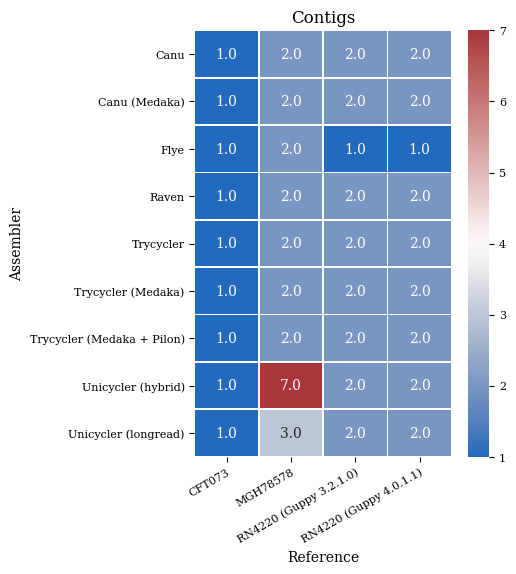

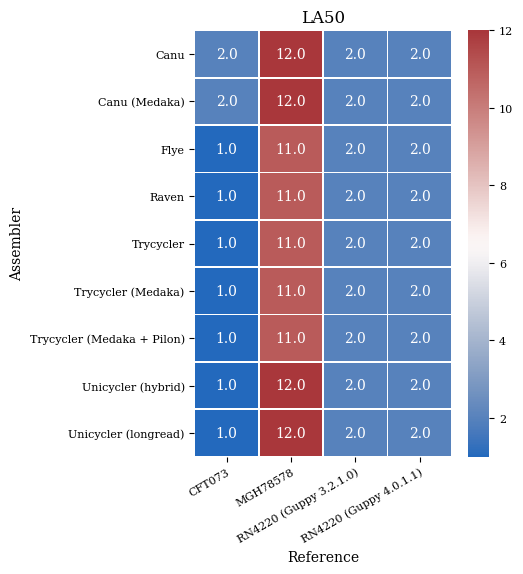

In [5]:
# Now the plotFeatureHeatmap method is called for a susbset of interesing metrics.
for feature, label in zip( [
    "# mismatches per 100 kbp",
    "# indels per 100 kbp",
    "    # translocations",
    "    # inversions",
    "    # relocations",
    "# local misassemblies",
    "# predicted genes (unique)",
    "# genomic features",
    "Genome fraction (%)",
    "# contigs",
    "LA50"
], [
    "Mismatches per 100 kbp",
    "Indels per 100 kbp",
    "Translocations",
    "Inversions",
    "Relocations",
    "Local misassemblies",
    r'$\dfrac{predicted~~features}{reference~~features}$',
    r'$\dfrac{recovered~~features}{reference~~features}$',
    "Genome fraction",
    "Contigs",
    "LA50"
] ) :
    plotFeatureHeatmap( feature, label, geneticFeatures = geneticFeatures )

---

####  Comparing predicted with annotated genes:

The `Quast` reports of the non sub-sample reference data sets revealed, that for the long read assemblies of the CFT073 and MGH78578 references many more genes were predicted than annotated genes are present. To investigate this, this script is used to caclculate:
- the distribution of gene lengths of annotated and predicted genes.
- the number of predicted genes that overlap reference genes. A predicted gene is considered to overlap a reference gene if at least 90% of it is contained in any reference gene (regarding the genomic positions, not the bases).  
It was hypothesized that errors in the long read sequences led to an interruption of detecting contiguos gene sequences. 

In [6]:
def plotGeneIntersections( genes, prediction, color="crimson", subtitle="", overlap=0.9 ) :
    ''' This method reads the files of annotated and predicted genes position in an assembly and:
    * visualizes the distribution of gene lengths.
    * the number of predicted genes that are fully contained in reference genes.
    * the number of predicted genes that are located outside of reference gene positions.
    
    Parameters
    ----------
    genes : str
        The path to a ...genomic_features_any.txt file generated with Quast. These files contain
        information about the position of annotated genes in the respective assembly.
    prediction : str
        The path to a ..._genemark_genes.gff.gz file generated with Quast. These files contain
        information about the position of predicted genes in the respective assembly.
    color : str
        A matplotlib color name for coloring the generated plots. Default is "cornflowerblue".
    subtitle : str
        A string that is used to construct the super title of the plot.
    '''

    # First, read in information of reference/annotated genes, i.e. pairs of start and stop locations.
    genes = pd.read_csv(open(genes), delimiter='\t')
    genes.drop( 0, inplace = True )
    genes.drop( "Unnamed: 1", axis = 1, inplace = True )
    genes.drop( "Type", axis = 1, inplace = True )
    genes.drop( "Contig", axis = 1, inplace = True )
    genes.rename( columns = { "ID or #":"ID", "Start":"s", "End":"e" }, inplace = True )
    genes = genes[ genes.ID.str.startswith( "gene" ) ]
    
    # Second, read in information of predicted genes, i.e. pairs of start and stop locations.
    with gzip.open(prediction) as prediction :
        line = prediction.readline( ).decode( "UTF-8" )
        IDs = [ ]
        starts = [ ]
        ends = [ ]
        strands = [ ]
        while line :
            if not ( line.startswith('##') or line.strip( ) == '' ) :
                splitLine = line.strip( ).split('\t')
                IDs.append( splitLine[ 8 ] )
                starts.append( splitLine[ 3 ] )
                ends.append( splitLine[ 4 ] )
                strands.append( splitLine[ 6 ] )
            line = prediction.readline( ).decode( "UTF-8" )
    d = { "ID" : IDs, "s" : starts, "e" : ends, "strand" : strands }
    predicted = pd.DataFrame( data = d )
    
    # Process information from true and predicted genes.
    genesIntervals = [ ] # Stores pairs of start and stop position of reference genes.
    predictedIntervals = [ ] # Stores pairs of start and stop position of predicted genes.
    genesLen = [ ] # Stores the length of reference genes.
    predictedLen = [ ] # Stores the length of predicted genes.
    for gs, ge in zip( genes.s.tolist( ), genes.e.tolist( ) ) :
        gs = int( gs )
        ge = int( ge )
        genesIntervals.append( ( gs, ge ) )
        genesLen.append( ge - gs )
    for ps, pe in zip( predicted.s.tolist( ), predicted.e.tolist( ) ) :
        ps = int( ps )
        pe = int( pe )
        predictedIntervals.append( ( ps, pe ) )
        predictedLen.append( pe - ps )
    
        
    genesCount = { }
    g = 1
    # For each reference gene start and stop position...
    for gs, ge in genesIntervals :
        count = 0 # Stores the count of fully contained predicted genes for the current reference gene.
        # ...iterate over all predicted genes start and stop position...
        for ps, pe in predictedIntervals :
            # ...if the predicted genes start is greater than the current reference genes start,
            # it can not be contained. The current count is stored and the next reference
            # gene is considered.
            if ps > ( ge + overlap ) :
                genesCount[ g ] = count
                count = 0
                g += 1
                break
            # ...if the predicted genes end is downstram of the current reference genes start,
            # we can head on to the next predicted gene.
            elif pe < gs :
                continue
            # ...if the predicted gene is fully contained, all positions overlap.
            elif ps >= gs and pe <= ge :
                overlappingPositions = pe - ps
            # ... if the predicted gene overlaps a prefix of a reference gene, the overlap is set to the end position
            # of the predicted gene minus the start position of the reference gene.
            elif ps < gs and pe < ge :
                overlappingPositions = pe - gs
            # ... if the predicted gene overlaps a suffix of a reference gene, the overlap is set to the end position
            # of the reference gene minus the start position of the predicted gene.
            elif ps > gs and pe > ge :
                overlappingPositions = ge - ps
            # ... if the predicted gene spans over the full reference gene, the overlap is set to all positions of
            # the reference gene.
            elif ps < gs and pe > ge :
                overlappingPositions = ge - gs
            # If the overlapping positions are at least 90% of all predicted gene positions, the count is increased.
            if overlappingPositions / ( pe - ps ) >= overlap :
                count += 1
                
    # Count number of predicted genes that do not overlap any reference genes:
    predictedGenes = len( predictedLen )
    containedPredictedGenes = sum( list( genesCount.values( ) ) )
    anyOutside = ( predictedGenes - containedPredictedGenes ) > 0
    
    # Prepare subplots.
    fig, axs = plt.subplots( nrows = 1, ncols = 2,
                             figsize = set_size( 550, 250 ) )
    # Plot histogram of overlapping predicted genes.
    values, bins, _ = axs[ 0 ].hist( list( genesCount.values( ) ), align="left", bins=list( range( 0, max( list( genesCount.values( ) ) ) + 1 ) ), color="dimgray", rwidth=0.8 )
    if anyOutside : # annotate non overlapping predicted genes.
        label = str( predictedGenes - containedPredictedGenes ) + " non overlapping predicted genes"
        #axs[ 0 ].legend( handles = [ mpatches.Circle( ( 0, 0 ), radius = 0, color = 'black', label = str( predictedGenes - containedPredictedGenes ) + " non overlapping predicted genes counted" ) ] );
        axs[ 0 ].annotate( label, xy = ( 0.2, 0.9 ), xycoords = 'axes fraction', textcoords = 'offset points',
                     bbox = dict( boxstyle = "round", fc = ( 1.0, 1.0, 1.0 ), ec = "k" ), fontsize = 8 )
        
    xticks = list( range( 0, max( list( genesCount.values( ) ) ) + 1 ) )
    axs[ 0 ].set_xticks( xticks[::2] if len( xticks ) > 10 else xticks )
    axs[ 0 ].set_xlabel( "Number of predicted genes with at least " + str( int( overlap * 100 ) ) + "% overlap" )

    axs[ 0 ].set_ylabel( "Number of reference genes" )
    axs[ 0 ].set_yscale("log")
    
    axs[ 0 ].set_title( "Reference genes grouped by number of\noverlapping predicted genes" );
    
    # Plot histogram of gene length distribution.
    maxGeneLen = max( [ max( genesLen ), max( predictedLen ) ] )
    binBorders = list( np.arange( 0, maxGeneLen + round( maxGeneLen / 20, -2 ) , round( maxGeneLen / 20, -2 ) ) )
    axs[ 1 ].hist( genesLen, label="reference genes", align="mid", rwidth=0.5, bins=binBorders, color="black", alpha=0.6 )
    axs[ 1 ].hist( predictedLen, label="predicted genes", align="mid", rwidth=0.2, bins=binBorders, color=color )

    axs[ 1 ].set_xticks( binBorders )
    plt.gca( ).xaxis.set_major_formatter( lambda x, pos : str( x / 1000 ) if pos % 3 == 0 else "" )
    axs[ 1 ].set_xlabel( "Gene length [kbp]" )
    
    axs[ 1 ].set_ylabel( "Number of genes" )
    axs[ 1 ].set_yscale("log")

    axs[ 1 ].legend( )

    axs[ 1 ].set_title( "Distribution of gene lengths" );
    
    plt.suptitle( subtitle )
    plt.tight_layout( )
    plt.show( )

In the following the method `plotGeneIntersections` is invoked on each report/assembler of the CFT073 and MGH78578 samples.

In [7]:
# List of all assembler names as used in the Quast report file names.
assemblers = [ "canu", "canu_medaka", "flye", "raven", "unicycler-longread", "unicycler-hybrid", "trycycler", "trycycler_medaka", "trycycler_medaka_pilon" ]
# Dictionary to map assembler names above to adjusted names for plotting.
assemblerLabels = { "canu" : "Canu",
                    "canu_medaka" : "Canu & Medaka",
                    "flye" : "Flye",
                    "raven" : "Raven",
                    "unicycler-longread" : "Unicycler (longread)",
                    "unicycler-hybrid" : "Unicycler (hybrid)",
                    "trycycler" : "Trycycler",
                    "trycycler_medaka" : "Trycycler & Medaka",
                    "trycycler_medaka_pilon" : "Trycycler & Medaka, Pilon" }

<ipython-input-6-cbeafada6062>:116: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  axs[ 0 ].annotate( label, xy = ( 0.2, 0.9 ), xycoords = 'axes fraction', textcoords = 'offset points',


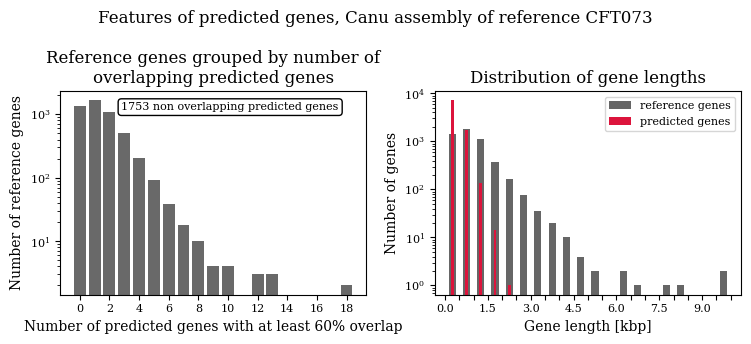

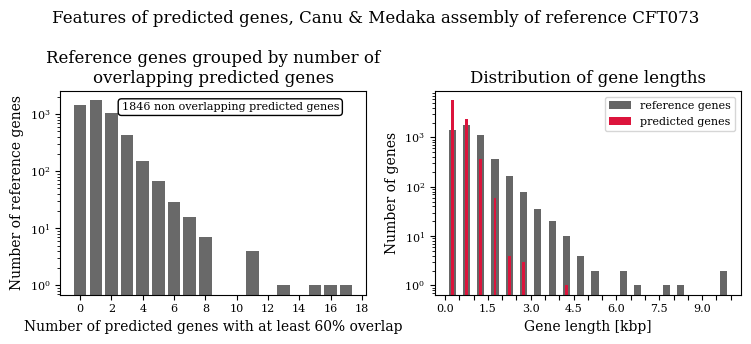

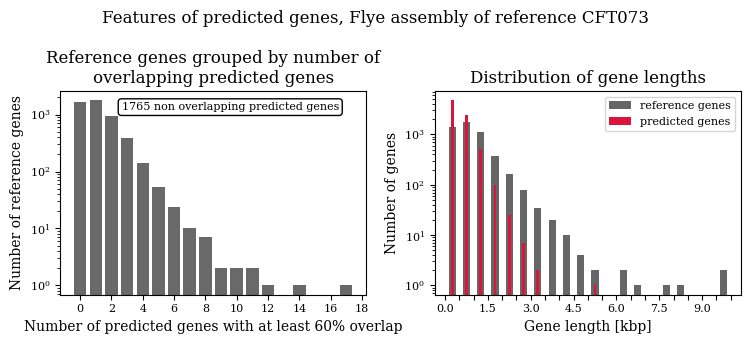

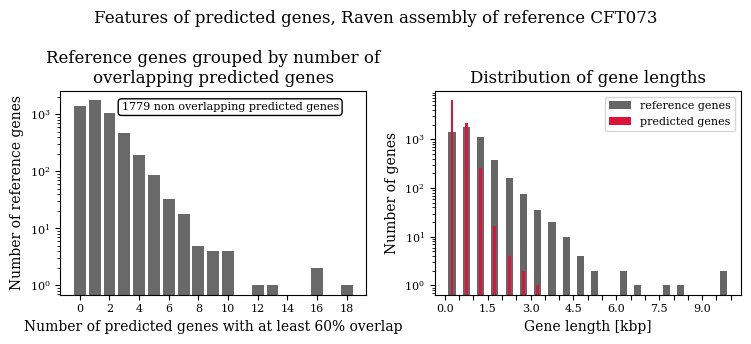

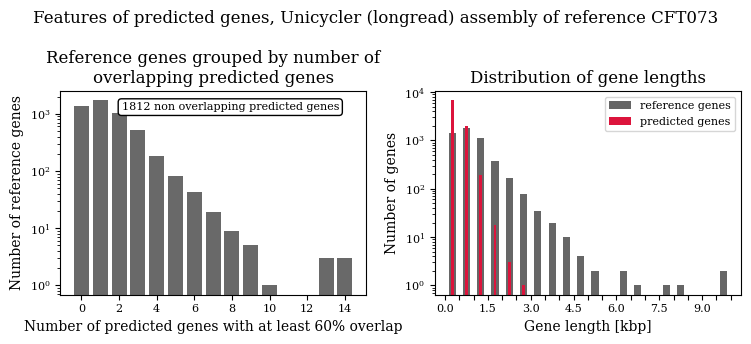

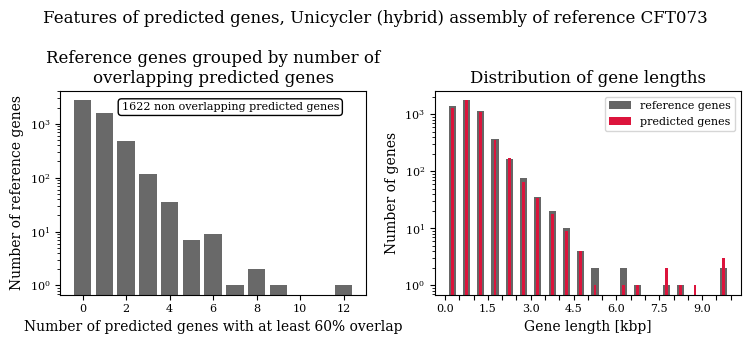

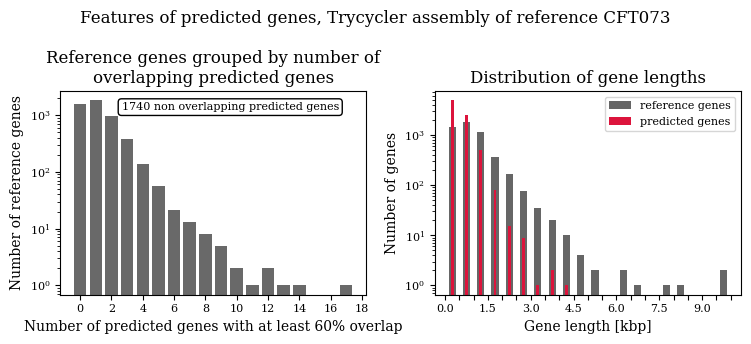

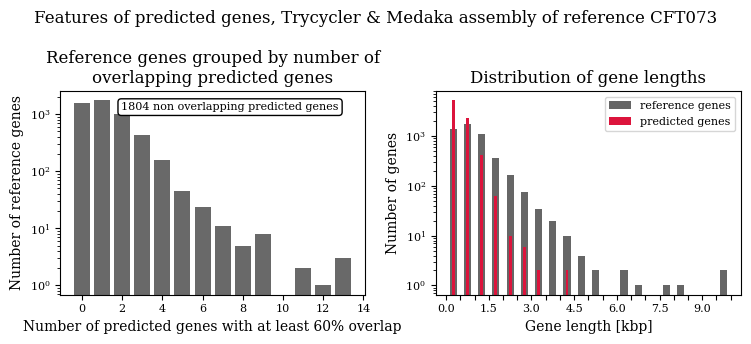

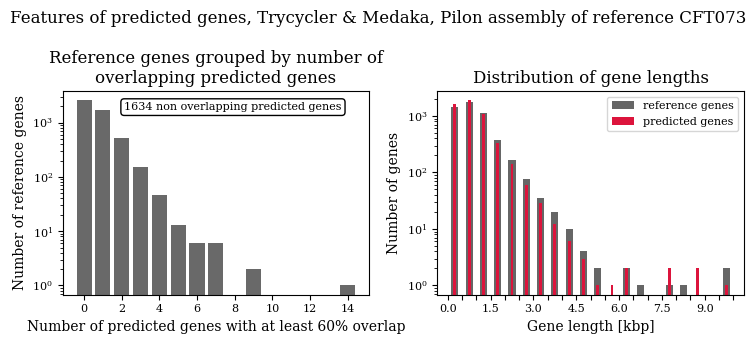

In [8]:
# Run on each assembly of CFT073
sample = "CFT073"
for assembler in assemblers :
    plotGeneIntersections(
        "./results/quast/" + sample + "/genome_stats/" + assembler + "_genomic_features_any.txt",
        "./results/quast/" + sample + "/predicted_genes/" + assembler + "_genemark_genes.gff.gz",
        subtitle= "Features of predicted genes, " + assemblerLabels[ assembler ] + " assembly of reference " + sample,
        overlap = 0.6
    )

<ipython-input-6-cbeafada6062>:116: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  axs[ 0 ].annotate( label, xy = ( 0.2, 0.9 ), xycoords = 'axes fraction', textcoords = 'offset points',


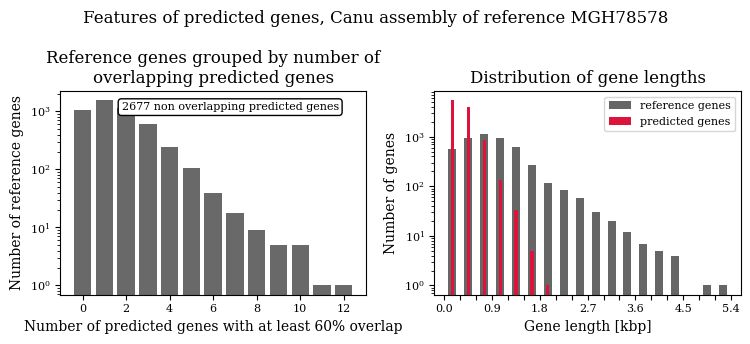

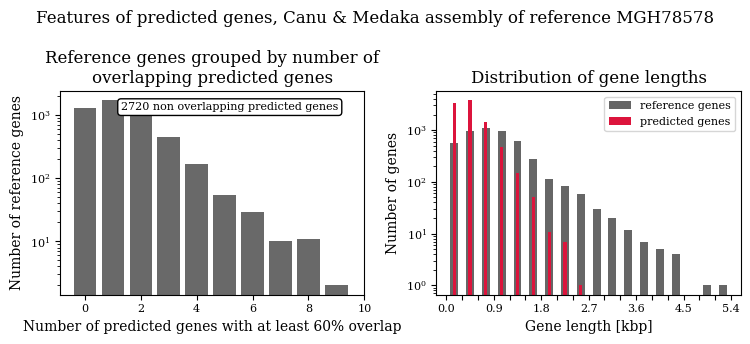

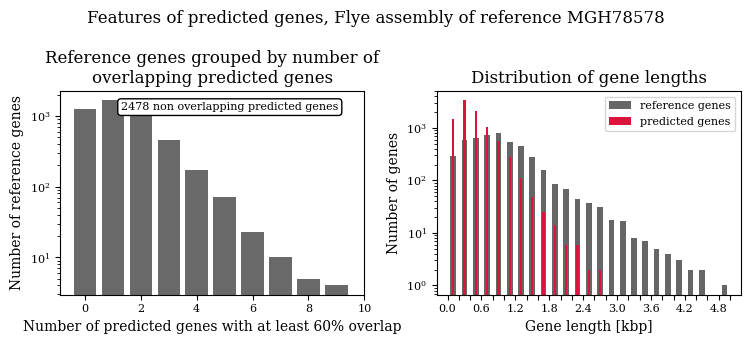

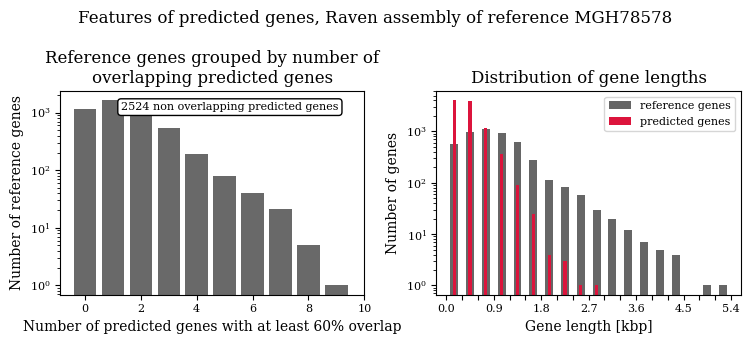

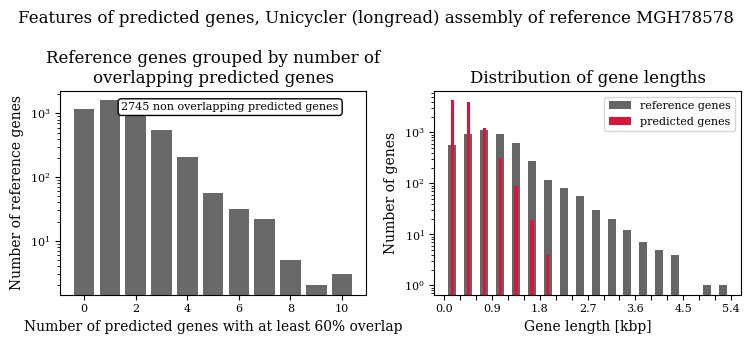

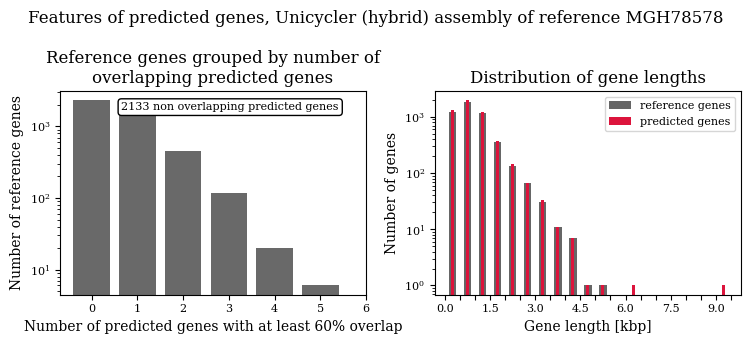

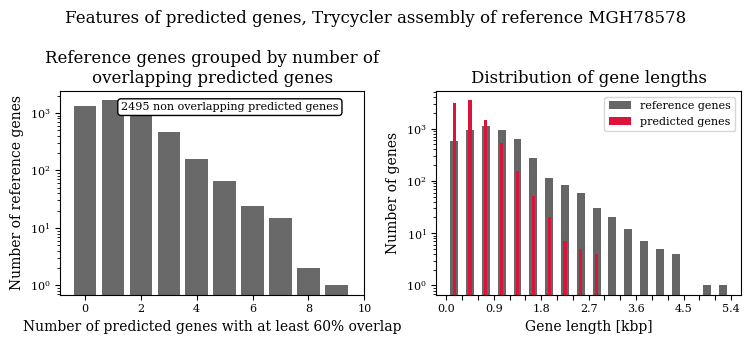

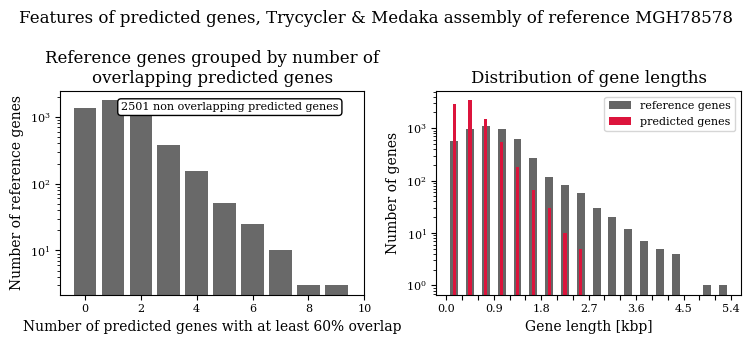

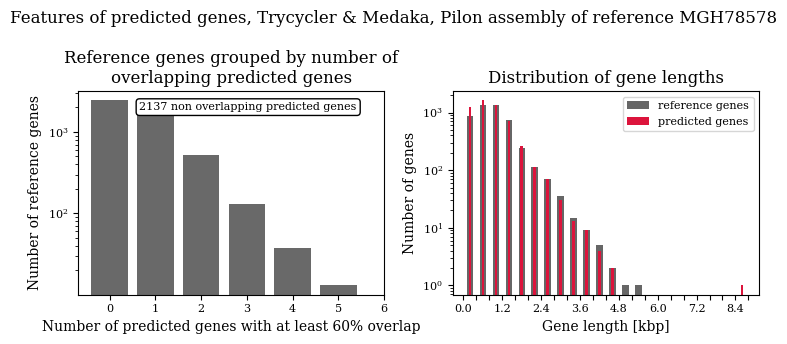

In [9]:
# Run on each assembly of MGH78578
sample = "MGH78578"
for assembler in assemblers :
    plotGeneIntersections(
        "./results/quast/" + sample + "/genome_stats/" + assembler + "_genomic_features_any.txt",
        "./results/quast/" + sample + "/predicted_genes/" + assembler + "_genemark_genes.gff.gz",
        subtitle= "Features of predicted genes, " + assemblerLabels[ assembler ] + " assembly of reference " + sample,
        overlap = 0.6
    )